In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import re
import math

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from pathlib import Path
import shutil


# Analysis for Correlation: Correlation Heat Matrix

## Setup

In [2]:

''' 
0) initial setups:
    - fonts (Times New Roman).
    - labels 
    - target var
    - colors

'''
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

label_map = {
    "CWSS": r"$C_{WSS}$",
    "CDOM": r"$C_{DOM}$",
    "CHA": r"$C_{HA}$",
    "CHE": r"$C_{HE}$",
    "CHu": r"$C_{Hu}$",
    "E4/E6 of HA": r"$E_{4}/E_{6}\ \mathrm{(HA)}$",
    "CHA/CFA": r"$C_{HA}/C_{FA}$",
    "Organic matter": r"Organic matter",
    "Maize yield": r"Maize yield",
    "HIX": r"HIX"
}


targets = ['Organic matter', 'Maize yield', 'E4/E6 of HA', 'CDOM', 'HIX', 'CHA/CFA', 'H/M of Exothermic Heat']


# your custom cmap
custom_cmap = LinearSegmentedColormap.from_list(
    "green_yellow_orange",
    ["#01756d", "#25c6b8", "#e8f9fa", "#fed5a9", "#fe8e2c"]
)



'''
1) clean ups

'''
df = pd.read_excel("Soil/PCA_data.xlsx")

# --- 0. Normalize function for names (columns, targets, label_map keys) ---
def normalize_name(s: str) -> str:
    s = str(s)
    # replace non-breaking/odd spaces with regular space
    s = (s.replace('\xa0', ' ')
           .replace('\u2009', ' ')
           .replace('\u2002', ' ')
           .replace('\u2003', ' ')
           .replace('\u200a', ' '))
    # collapse multiple spaces/tabs/newlines to single space
    s = re.sub(r'\s+', ' ', s)
    # unify common punctuation variants (optional, helps future-proof)
    s = (s.replace('–', '-')    # en dash -> hyphen
           .replace('—', '-')   # em dash -> hyphen
           .replace('／', '/')  # fullwidth slash -> slash
           .replace('：', ':')) # fullwidth colon -> colon
    return s.strip()

# 1) Clean df column names IN-PLACE
df = df.drop(columns='group')
old_cols = list(df.columns)
df.rename(columns=lambda c: normalize_name(c), inplace=True)

# choose the numeric table to analyze
X = df.select_dtypes(include=['number']).copy()

outT = []
outF = []
for everything in X.columns:
    if everything in targets:
        outT.append(everything)
    else:
        outF.append(everything)

print('targets are: ', outT)
print('features are: ', outF)


# sanity checks: keep only targets that exist; warn on any missing
missing = [t for t in targets if t not in X.columns]
if missing:
    print("⚠️ Missing targets (skipped):", missing)
targets = [t for t in targets if t in X.columns]
if not targets:
    raise ValueError("None of the specified targets are present in the dataframe columns.")

    



targets are:  ['Organic matter', 'Maize yield', 'CDOM', 'HIX', 'E4/E6 of HA', 'CHA/CFA', 'H/M of Exothermic Heat']
features are:  ['Available P', 'CWSS', 'CHA', 'CHE', 'CHu', 'H/C ratio', 'C/N ratio', 'O/C ratio', 'HMi/HMc', '(HMi+HMc)/HM', 'Aliphatic C/Aromatic C']


## run corr matrix

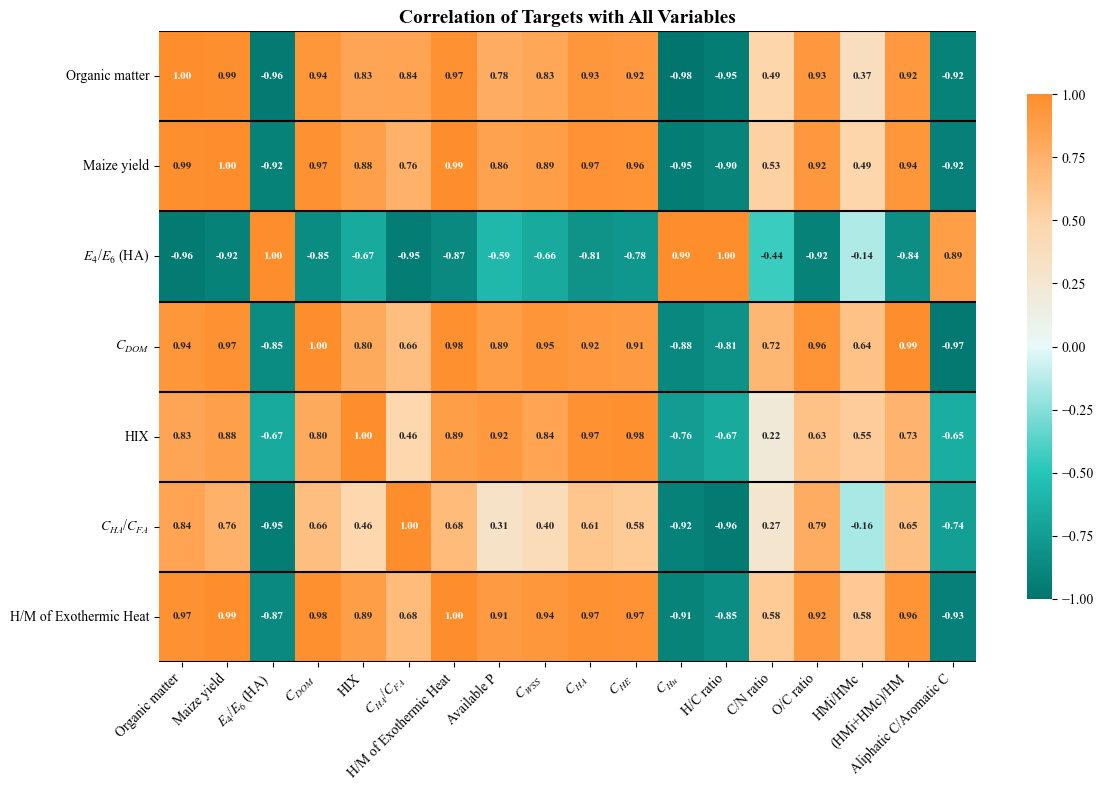

In [3]:

# 2) compute correlation matrix for all vars, then slice target rows
corr_all = X.corr(method='pearson')
corr_matrix = corr_all.loc[targets]   # targets (rows) vs all variables (cols)

# 3) apply pretty labels to rows+cols
row_labels = [label_map.get(r, r) for r in corr_matrix.index]
col_labels = [label_map.get(c, c) for c in corr_matrix.columns]
corr_matrix.index = row_labels
corr_matrix.columns = col_labels

# 4) (optional) reorder columns so targets appear first (nice for reading)
targets_pretty = [label_map.get(t, t) for t in targets]
ordered_cols = targets_pretty + [c for c in corr_matrix.columns if c not in targets_pretty]
corr_matrix = corr_matrix.loc[:, ordered_cols]


# 5) symmetric color range around 0 so colors are comparable
vmax = np.nanmax(np.abs(corr_matrix.values))
vmin = -vmax


plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    corr_matrix,
    annot=True, fmt=".2f",
    cmap=custom_cmap, center=0, vmin=vmin, vmax=vmax,
    annot_kws={"size":8, "weight":"bold"},
    cbar_kws={"shrink": 0.8}
)

# 6) highlight target rows with horizontal lines
# (they’re at indices 0..len(targets)-1 **after** we sliced loc[targets] above)
for i in range(len(targets_pretty)):
    ax.axhline(i, color='black', lw=1.5)

# draw a line after the last row as well to box it in
ax.axhline(len(corr_matrix), color='black', lw=1.5)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Correlation of Targets with All Variables", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## correlation heat matrix finished!

# Analysis for Importance Ranking: Random-Forest

In [4]:
OUT_DIR = Path("Soil/figs")      # <- your output folder

# safety guard (optional but smart)
assert OUT_DIR.name == "figs", "Refusing to delete a non-figs directory."

# delete the whole folder (if it exists), then recreate it empty
shutil.rmtree(OUT_DIR, ignore_errors=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Cleared:", OUT_DIR.resolve())

Cleared: /Users/chf/Soil/figs


target is: [Organic matter] rows=4, feats=17
target is: [Maize yield] rows=4, feats=17
target is: [E4/E6 of HA] rows=4, feats=17
target is: [CDOM] rows=4, feats=17
target is: [HIX] rows=4, feats=17
target is: [CHA/CFA] rows=4, feats=17
target is: [H/M of Exothermic Heat] rows=4, feats=17


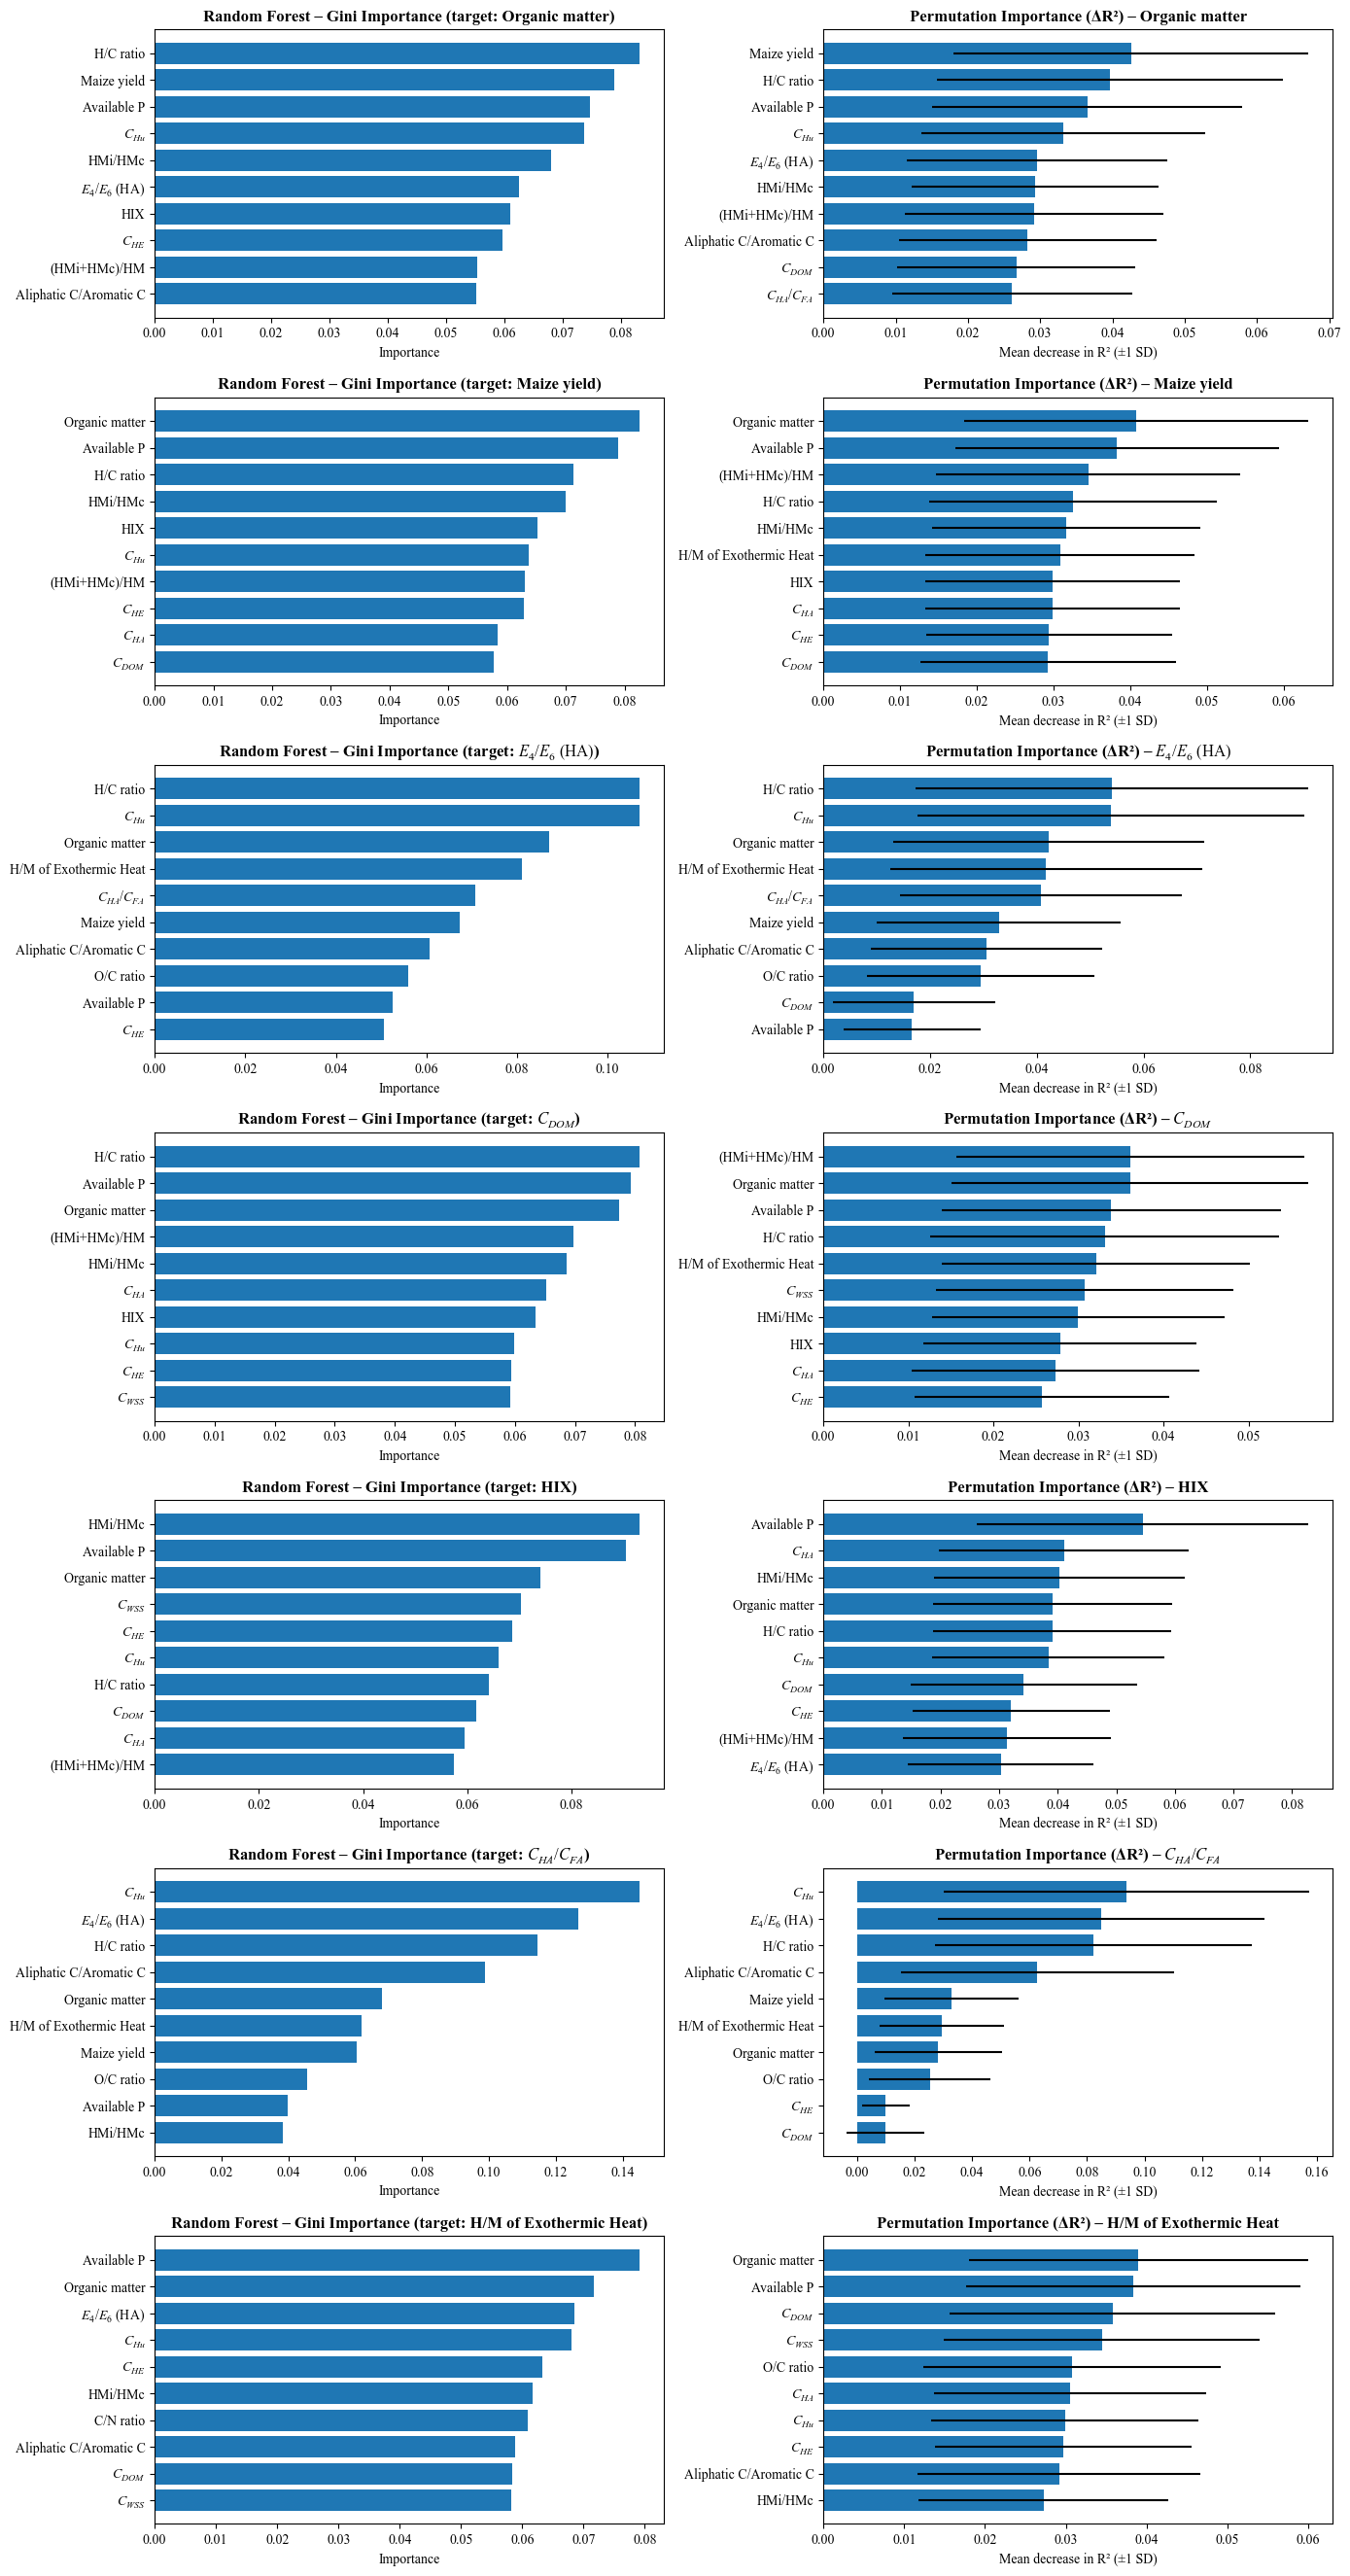

,target,rows,R2,MAE,RMSE
0,Organic matter,4,0.096098,1.395750,1.767196
1,Maize yield,4,0.186780,202.463125,239.476346
2,E4/E6 of HA,4,-0.128983,0.123138,0.145178
3,CDOM,4,0.200285,0.031617,0.031932
4,HIX,4,-0.347533,1.451567,2.038047
5,CHA/CFA,4,-0.660038,0.127229,0.151081
6,H/M of Exothermic Heat,4,0.214528,0.136675,0.152737


In [5]:
# ================= SAVE-EVERYTHING VERSION =================
import os
from matplotlib.backends.backend_pdf import PdfPages

os.makedirs("figs", exist_ok=True)  # where all files will be written

def safe_name(s):
    return "".join(c if c.isalnum() or c in "._-" else "_" for c in str(s))

# --- knobs ---
top_k = 10
n_repeats = 30

# numeric matrix once (drop zero-variance)
X_num_all = df.select_dtypes(include=[np.number]).copy()
X_num_all = X_num_all.loc[:, X_num_all.nunique(dropna=True) > 1]

# keep only targets that exist in df
targets_to_run = [t for t in targets if t in df.columns]
if not targets_to_run:
    raise ValueError("No valid targets found in dataframe.")

# figure: 2 columns (Gini | Permutation), one row per target
nrows = len(targets_to_run)
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(14, 3.8*nrows))
if nrows == 1:
    axes = np.array([axes])  # ensure 2D indexing

summary_rows = []

# also collect per-target pages in a single multi-page PDF
with PdfPages("Soil/figs/importance_all_targets.pdf") as pdf:

    for r, TARGET in enumerate(targets_to_run):
        # -- build X, y for this target --
        y = pd.to_numeric(df[TARGET], errors="coerce")
        mask = y.notna()
        y = y.loc[mask]

        X = X_num_all.loc[mask].copy()
        X = X.drop(columns=[c for c in X.columns if c == TARGET], errors="ignore")
        X = X.replace([np.inf, -np.inf], np.nan)

        imp = SimpleImputer(strategy="median")
        X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)

        n_samples, n_features = X_imp.shape
        print(f"target is: [{TARGET}] rows={n_samples}, feats={n_features}")
        if n_samples < 3 or n_features < 1:
            print("   ↳ skipped (not enough data after cleaning)")
            continue

        # -- CV choice --
        if n_samples <= 6:
            cv = LeaveOneOut()
            cv_label = f"LOOCV (n={n_samples})"
            rf_cv = RandomForestRegressor(n_estimators=600, max_features="sqrt", random_state=42, n_jobs=-1)
            y_hat = cross_val_predict(rf_cv, X_imp, y, cv=cv, n_jobs=-1)
            R2 = r2_score(y, y_hat)
            MAE = mean_absolute_error(y, y_hat)
            RMSE = mean_squared_error(y, y_hat, squared=False)
        else:
            cv = KFold(n_splits=5, shuffle=True, random_state=42)
            cv_label = "5-fold CV"
            rf_cv = RandomForestRegressor(n_estimators=600, max_features="sqrt", random_state=42, n_jobs=-1)
            r2s = cross_val_score(rf_cv, X_imp, y, scoring="r2", cv=cv, n_jobs=-1)
            R2, MAE, RMSE = float(np.mean(r2s)), np.nan, np.nan

        # -- fit final model --
        rf = RandomForestRegressor(n_estimators=600, max_features="sqrt", random_state=42, n_jobs=-1)
        rf.fit(X_imp, y)

        # ---------- compute importances ----------
        gini_imp = pd.Series(rf.feature_importances_, index=X_imp.columns).sort_values()
        gini_top = gini_imp.tail(min(top_k, len(gini_imp)))

        perm = permutation_importance(rf, X_imp, y, scoring="r2",
                                      n_repeats=n_repeats, random_state=42, n_jobs=-1)
        perm_imp = pd.Series(perm.importances_mean, index=X_imp.columns).sort_values()
        perm_err = pd.Series(perm.importances_std, index=X_imp.columns).loc[perm_imp.index]
        perm_top = perm_imp.tail(min(top_k, len(perm_imp)))
        perm_err_top = perm_err.loc[perm_top.index]

        # ---------- draw on BIG GRID ----------
        ax_g = axes[r, 0]
        ax_g.barh([label_map.get(c, c) for c in gini_top.index], gini_top.values)
        ax_g.set_title(f"Random Forest – Gini Importance (target: {label_map.get(TARGET, TARGET)})",
                       fontweight="bold")
        ax_g.set_xlabel("Importance")
        ax_g.set_ylabel("")

        ax_p = axes[r, 1]
        ax_p.barh([label_map.get(c, c) for c in perm_top.index], perm_top.values, xerr=perm_err_top.values)
        ax_p.set_title(f"Permutation Importance (ΔR²) – {label_map.get(TARGET, TARGET)}",
                       fontweight="bold")
        ax_p.set_xlabel("Mean decrease in R² (±1 SD)")
        ax_p.set_ylabel("")

        summary_rows.append({"target": TARGET, "rows": n_samples, "R2": R2, "MAE": MAE, "RMSE": RMSE})

        # ---------- ALSO: make a PER-TARGET FIGURE and SAVE ----------
        fig_t, axs_t = plt.subplots(1, 2, figsize=(14, 4))
        # left
        axs_t[0].barh([label_map.get(c, c) for c in gini_top.index], gini_top.values)
        axs_t[0].set_title(f"Random Forest – Gini Importance (target: {label_map.get(TARGET, TARGET)})",
                           fontweight="bold")
        axs_t[0].set_xlabel("Importance")
        # right
        axs_t[1].barh([label_map.get(c, c) for c in perm_top.index], perm_top.values, xerr=perm_err_top.values)
        axs_t[1].set_title(f"Permutation Importance (ΔR²) – {label_map.get(TARGET, TARGET)}",
                           fontweight="bold")
        axs_t[1].set_xlabel("Mean decrease in R² (±1 SD)")
        fig_t.tight_layout()

        base = f"figs/importance_{safe_name(TARGET)}"
        fig_t.savefig(base + ".png", dpi=400, bbox_inches="tight")
        fig_t.savefig(base + ".svg",            bbox_inches="tight")
        pdf.savefig(fig_t, bbox_inches="tight")   # append to the combined PDF
        plt.close(fig_t)

# finish + save the BIG GRID
fig.tight_layout()
fig.savefig("Soil/figs/importance_grid_all.png", dpi=400, bbox_inches="tight")
fig.savefig("Soil/figs/importance_grid_all.pdf",            bbox_inches="tight")
plt.show()

summary_df = pd.DataFrame(summary_rows)
summary_df
# ===========================================================


## what top feature in importance ranking means

if you cut the data at some threshold of that feature, the two groups have much more consistent (less variable) yields than before. 

In other words, that feature is good at separating high vs low yield (or different yield levels), so it reduces prediction error a lot.
